# Import Packages

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.reset_orig()
from scipy import interpolate
from scipy import signal
from scipy import stats

# Make Data Path and Figure Path
These are "input" and "output" paths for the program to read and write data.

In [104]:
data_path='/Users/danielbabin/Documents/LamontColumbia/U1474_Paper/Data/'
figure_path='/Users/danielbabin/Documents/LamontColumbia/U1474_Paper/Figures/'

# Import XRF Data
We will import the XRF data as a dataframe using pandas. The data takes the form of "counts," or relative abundances, of elements at 2 mm depth intervals along the 255 m long length of the core "Splice." Also included in the raw depth are descriptive information about the Site and Expedition, as well as information about machine settings during scanning. I list the columns below.

In [105]:
xrf=pd.read_csv(data_path+'U1474_XRF_Splice rereduced.csv',low_memory=False,index_col='Depth CCSF (m)')

In [106]:
xrf.columns

Index(['Exp', 'Site', 'Hole', 'Core', 'Type', 'Section', 'Sec half',
       'Section length (cm)', 'Top depth CCSF (m)', 'Bottom depth CCSF (m)',
       'Splice Tie Point -Samples Start At (cm)',
       'Splice Tie Point -Samples Stop At (cm)', 'In the Splice?',
       'position (mm)', 'sample surface', 'validity', 'E-gain', 'E-offset',
       'F-slope', 'F-offset', 'cps', 'MSE', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl',
       'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Mn', 'Fe', 'Ni', 'Cu', 'Zn', 'As',
       'Br', 'Rb', 'Sr', 'Zr', 'Sb', 'Ba', 'La', 'Nd', 'Pb', 'Th', 'U',
       'Cr kb', 'Ca ka-a sum', 'Ca ka-b sum', 'S2', 'W la', 'W la scat',
       'W lb1', 'W lb1 scat', 'W lb2', 'W lb2 scat', 'Cr inc', 'Cr coh', 'Dt',
       'filename'],
      dtype='object')

# Manipulate XRF Data
Here in this section will be the bulk of our data cleaning and preparation
## Clean the XRF Data
We would like to make a dataframe that has exactly the information we'd like to manipulate: high quality data of elements at depth.
### Drop measurements at depths not in the "Splice"
The raw data contains every measurement we made on every section of the core. IODP takes long cores from many different, nearby holes at a site, which tend to be incomplete. However, these cores can be correlated to form a continuous record, called the splice. Because these correlations could occur at any depth in the core, at which point we might transition to another core, some measurements we took are not in the splice. We need to drop those.

In [107]:
xrf=xrf[xrf['In the Splice?']==True]

How big is our dataset?

In [108]:
xrf.shape

(119233, 65)

Visualize time series:

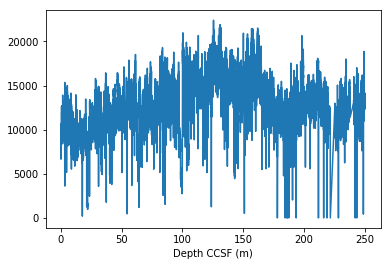

In [109]:
xrf['K'].plot()

Make a column that has a unique core section identifier

In [110]:
xrf['section_ID']=xrf['Hole'].map(str) + xrf['Core'].map(str) + xrf['Type'].map(str) + xrf['Section'].map(str) 

### Investigate and drop some problem sections
Some sections were have "counts," the measure of abundance, much lower than other sections. Checking the raw data reveals they were scanned at low voltage. Here, we drop them from the dataframe

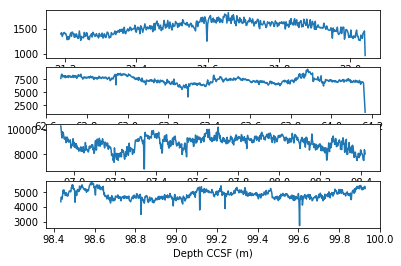

In [111]:
fig,axes=plt.subplots(nrows=4)
xrf[xrf['section_ID']=='D4H1']['K'].plot(ax=axes[0])
xrf[xrf['section_ID']=='D8H3']['K'].plot(ax=axes[1])
xrf[xrf['section_ID']=='D11H4']['K'].plot(ax=axes[2])
xrf[xrf['section_ID']=='D11H5']['K'].plot(ax=axes[3])

In [112]:
clean_xrf=xrf
dropped_sections = ['D4H1','D8H3','D11H4','D11H5']
for i in dropped_sections:
    clean_xrf=clean_xrf[clean_xrf['section_ID'] != i].dropna()

### Drop rows where any major elemental datum = 0
These measurements would likely reflect cracks or the ends of cores

In [194]:
clean_zeroless_xrf=clean_xrf[(clean_xrf[['Al','Si','K','Ca','Ti','Fe']] != 0).all(1)]
clean_zeroless_xrf=clean_zeroless_xrf[clean_zeroless_xrf['Cr coh'] > 14000]
clean_zeroless_xrf=clean_zeroless_xrf[clean_zeroless_xrf['Cr coh'] < 40000]

### Check the MSE to ensure good data
"MSE" provides an estimate of the quality of fit the ITRAX program Q-spec was able replicate the returned spectra from the x-ray bombardment with a spectral model, which it can convert to elements.

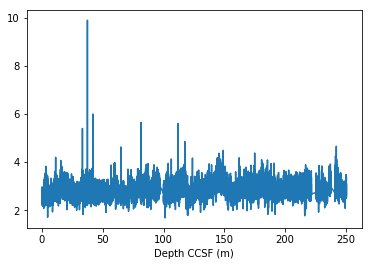

In [195]:
clean_zeroless_xrf['MSE'].plot()

No long sections have anomalously high MSE, which would be expected for a problematic section

### Sort by depth, delete duplicates, and save "cleaned" raw data
Saving the clean raw data now will allow other scientists, interested in reanalyzing my data, to have it in its most basic form

In [196]:
clean_zeroless_xrf = clean_zeroless_xrf[~clean_zeroless_xrf.index.duplicated(keep='first')].copy()
clean_zeroless_xrf=clean_zeroless_xrf.sort_index().copy()
clean_zeroless_xrf.to_csv(data_path+'clean_xrf.csv')

## Check Quality of Raw XRF Data
It is common to calibrate X-Ray Flourescense data with well constrained concentration data. Here we provide elemental flux fusion concentrations of discrete sediment samples at different core depths for our calibration.
At this point, we can assess the quality of our raw data by comparing the xrf counts, relative abundances, to absolute concentrations from our calibration dataset
### Import Calibration Dataset

In [197]:
reference_conc_raw=pd.read_csv(data_path+'mad_samples_bulk.csv',index_col='Depth')

Select elements we want

In [198]:
reference_conc=reference_conc_raw[['Al','Si','K','Ca','Ti','Fe']]

### Prepare "Counts" dataframe for comparison
We need to make an dataframe of xrf counts identical in size to the calibration data (reference_conc), extracted from the big xrf dataframe at the depth of the calibration samples. This way, we can directly compare counts at a depth to concentration at a depth.
<br> cts_check will be this dataframe. Right now it is empty.

In [199]:
cts_check=pd.DataFrame(columns=reference_conc.columns)

Here we first make a dataframe of just the elements we want from the clean xrf data. We then sort through this dataframe to find the depths of the calibration samples, and then add those measurements to the dataframe "cts_check"

In [200]:
xrf_check=clean_zeroless_xrf[reference_conc.columns]
for i in reference_conc.index:
    idx=xrf_check.index.get_loc(i,method='nearest')
    cts_check.loc[xrf_check.iloc[idx].name]=xrf_check.iloc[idx]

Both dataframes are made, the identical in size, and ready for comparison

In [201]:
reference_conc.shape

(23, 6)

In [202]:
cts_check.shape

(23, 6)

### Define function r2 to assess correlation

In [203]:
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

### Compare raw data and calibration data to assess quality

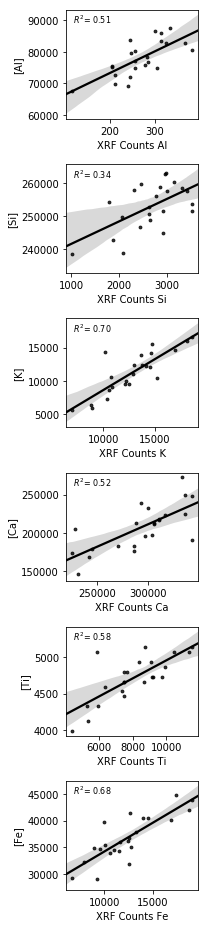

In [204]:
fig,axes=plt.subplots(nrows=6,figsize=(3,13))
for i,col in enumerate(reference_conc.columns):
    sns.regplot(cts_check[col],reference_conc[col],color='k',ax=axes[i],scatter_kws={'s':8})
    text=str('$R^2$= '+r2(cts_check[col],reference_conc[col]).astype(str)[:4])
    axes[i].text(0.05, .97, text,
        verticalalignment='top', horizontalalignment='left',
        transform=axes[i].transAxes, fontsize=8)
    axes[i].set_ylabel('['+col+']')
    axes[i].set_xlabel('XRF Counts '+col)
plt.tight_layout()
fig.savefig(figure_path+'xrf_raw_vs_calibration.png')

It seems even our raw xrf data, prior to processing, is okay. Relative abunances reliably predict concentration

## Normalize XRF Data
The ITRAX is capable of measuring a wide array of elements, from light major elements like Aluminum to heavy trace elements like Neodymium. However, trace elements are far less reliable, requiring longer measurement times and careful calibration. 
<br> Water content varies downcore. This can have the effect of diluting counts of other elements geologists might be interested in.
<br> These factors combined make normalizing xrf data to total counts a common practice. Here we normalize our xrf data to the total counts of the major elements we are interested in. 
### Normalize by counts

In [205]:
total_cts=clean_zeroless_xrf[['Al','Si','K','Ca','Ti','Fe']].sum(axis=1) #sum across the rows of elements we want
normed_elems=clean_zeroless_xrf[['Al','Si','K','Ca',
                                 'Ti','Fe']].div(total_cts,axis=0).mul(total_cts.mean(),axis=0).dropna()
#divide by total counts, restore by returning the mean of the column total_cts

Below we check the effect of our normalization on the comparison to our calibration dataset. We will do this many times, so I have combined and automated the depth extraction and plotting function into a function called "compare"

### Define Compare

In [206]:
def compare(input_df,im_name):
    cts_check=pd.DataFrame(columns=reference_conc.columns)
    xrf_check=input_df
    for i in reference_conc.index:
        idx=xrf_check.index.get_loc(i,method='nearest')
        cts_check.loc[xrf_check.iloc[idx].name]=xrf_check.iloc[idx]
    fig,axes=plt.subplots(nrows=6,figsize=(3,13))
    for i,col in enumerate(reference_conc.columns):
        sns.regplot(cts_check[col],reference_conc[col],color='k',ax=axes[i],scatter_kws={'s':8})
        text=str('$R^2$= '+r2(cts_check[col],reference_conc[col]).astype(str)[:4])
        axes[i].text(0.05, .97, text,
            verticalalignment='top', horizontalalignment='left',
            transform=axes[i].transAxes, fontsize=8)
        axes[i].set_ylabel('['+col+']')
        axes[i].set_xlabel('XRF Counts '+col)
    plt.tight_layout()
    fig.savefig(figure_path+im_name)

### Compare Normalized data and calibration

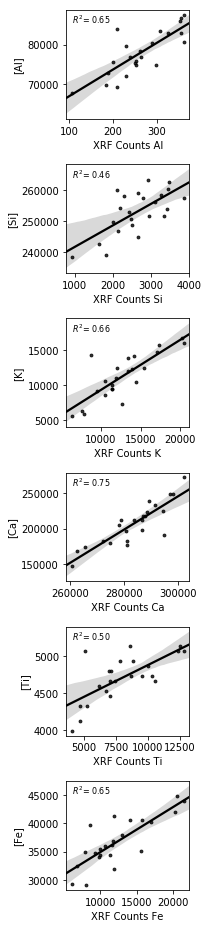

In [207]:
compare(normed_elems,'normed_xrf_vs_calibration.png')

### Compare Normalized data and calibration

In [208]:
cr_normed_elems=normed_elems.copy()

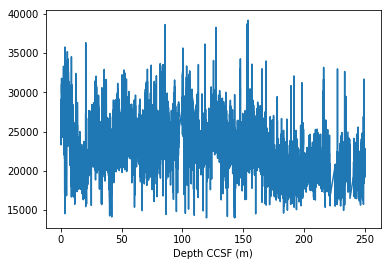

In [209]:
clean_zeroless_xrf['Cr coh'].plot()

In [210]:
cr_normed_elems[['K','Ti','Fe']]=normed_elems[['K','Ti','Fe']].div(
    clean_zeroless_xrf['Cr coh'],axis=0).mul(clean_zeroless_xrf['Cr coh'].mean(),axis=0) #improves Fe and Ti

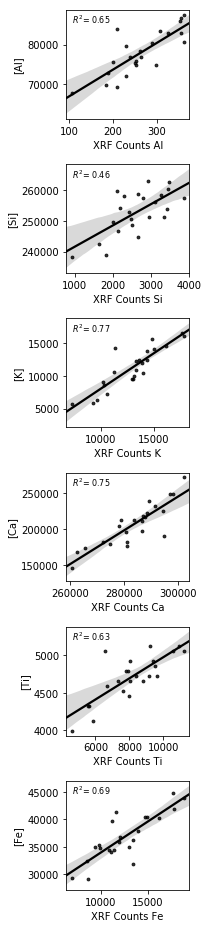

In [211]:
compare(cr_normed_elems,'cr_normed_xrf_vs_calibration.png')

The result is a dataset of counts that looks more like the calibration dataset. <br>
Save the dataframe as a csv

In [212]:
cr_normed_elems.to_csv(data_path+'normed_elems.csv')

## Apply an outlier remover function
I was given some code used by Allison Grant et al. 2017 that removes outliers, using an isometric log ratio transformation and mahalanobis distance. However, the code is in Matlab. So if you want to run this code in python:

Open an anaconda terminal and change to the directory: "matlabroot\extern\engines\python" <br>
Run setup.py file: python setup.py install
Link to Mathworks website with info on installation: <br>
https://www.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html

### Activate Matlab Engine

In [213]:
import matlab.engine
eng = matlab.engine.start_matlab()

### Convert dataframe into form usable by matlab

In [214]:
matlab_compatible_matrix=np.c_[cr_normed_elems.index.values,cr_normed_elems.values]

In [215]:
mat_ML = matlab.double(matlab_compatible_matrix.tolist())

### Apply outlier removal function

In [216]:
cleaned_ML=eng.apply_cutoff(mat_ML,2)

### Convert back into python data

In [217]:
cleaned=np.array(cleaned_ML._data.tolist())

In [218]:
row_num=int(cleaned.shape[0]/8)
cleaned=cleaned.reshape(8,row_num).transpose()
cleaned=pd.DataFrame(cleaned,columns=['Depth (m)','Al', 'Si', 'K', 'Ca', 'Ti', 'Fe','d1'])
cleaned=cleaned.set_index('Depth (m)')

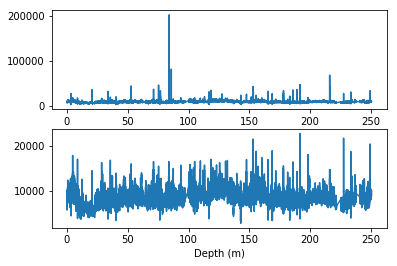

In [219]:
fig,ax=plt.subplots(nrows=2)
cr_normed_elems['Ti'].plot(ax=ax[0])
cleaned['Ti'].plot(ax=ax[1])

### Compare cleaned data and calibration

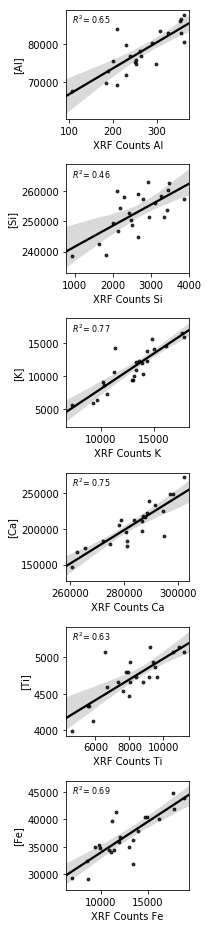

In [220]:
compare(cleaned,'cleaned_vs_calibration.png')

## Integrate data in 2 cm increments
The original plan with the XRF core scan was to have the data output at 2 cm intervals. We however discovered that regardless, the machine makes measurements at 2 mm interval. If we selected a 2 cm output, the machine would sum/average 10 measurements for us. So we chose to get the raw data, and perform the calculation ourselves. 

This sort of data manipulation is called a boxcar filter, where every point in the filter has equal weight. 
### Make boxcar window

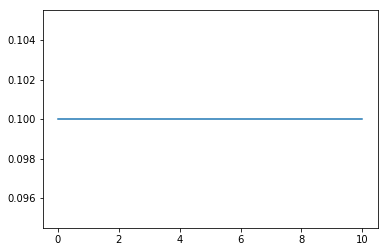

In [221]:
box=signal.boxcar(10)
box=box/sum(box)
fig,ax=plt.subplots()
ax.plot(np.linspace(0,10,10),box)

### Apply Filter

In [222]:
box_filt=cleaned.rolling(10,min_periods=10,center=True).apply(func=lambda x: np.dot(box,x),raw=True).dropna()

### Save filtered results

In [223]:
box_filt.to_csv('xrf_counts_boxcar.csv')

### Compare smoothed data to calibration

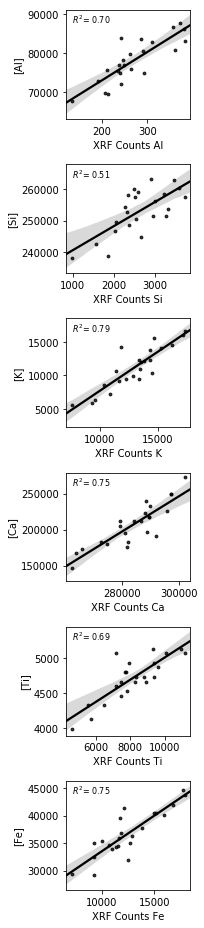

In [224]:
compare(box_filt,'filtered_vs_calibration.png')

## Convert counts to concentrations
We convert xrf counts, relative abundance, to absolute concentrations using the procedure of Weltje et al., 2008. The procedure uses a Univariate log-ratio calibration. In our dataset, we compare all elements to Ca.
### Set up ratios
#### Create dataframe of xrf scan rations

In [225]:
box_filt_ratios=pd.DataFrame(index=box_filt.index)
box_filt_ratios['Al/Ca']=box_filt['Al']/box_filt['Ca']
box_filt_ratios['Si/Ca']=box_filt['Si']/box_filt['Ca']
box_filt_ratios['K/Ca']=box_filt['K']/box_filt['Ca']
box_filt_ratios['Ca/Ca']=box_filt['Ca']/box_filt['Ca']
box_filt_ratios['Ti/Ca']=box_filt['Ti']/box_filt['Ca']
box_filt_ratios['Fe/Ca']=box_filt['Fe']/box_filt['Ca']

#### Create dataframe of reference concentration ratios
Review calibration dataset

In [226]:
reference_conc.head()

,Al,Si,K,Ca,Ti,Fe
Depth,,,,,,
1.000,75248.770,254286.816,7305.2936,205119.187,4663.4770,35041.5933
10.365,67664.642,238393.890,5644.9996,272301.081,3997.2660,29306.2427
16.963,72819.479,242600.841,5894.0437,249430.649,4330.3715,34971.6500
19.963,69797.678,238861.329,6309.1172,248715.948,4130.5082,32383.7479
30.626,74893.264,258026.328,8633.5288,239424.835,4663.4770,35391.3098


Create ratios

In [227]:
ref_conc_ratios=pd.DataFrame(index=reference_conc.index)
ref_conc_ratios['Al/Ca']=reference_conc['Al']/reference_conc['Ca']
ref_conc_ratios['Si/Ca']=reference_conc['Si']/reference_conc['Ca']
ref_conc_ratios['K/Ca']=reference_conc['K']/reference_conc['Ca']
ref_conc_ratios['Ca/Ca']=reference_conc['Ca']/reference_conc['Ca']
ref_conc_ratios['Ti/Ca']=reference_conc['Ti']/reference_conc['Ca']
ref_conc_ratios['Fe/Ca']=reference_conc['Fe']/reference_conc['Ca']

#### Create dataframe of counts ratios at calibration sample depths
First extract counts at depth

In [228]:
cts_check=pd.DataFrame(columns=reference_conc.columns)

for i in reference_conc.index:
    idx=box_filt.index.get_loc(i,method='nearest')
    cts_check.loc[box_filt.iloc[idx].name]=box_filt.iloc[idx].copy()

model = [stats.linregress(cts_check[i],reference_conc[i]) for i in reference_conc.columns]

Create ratios

In [229]:
cts_check_ratios=pd.DataFrame(index=cts_check.index)
cts_check_ratios['Al/Ca']=cts_check['Al']/cts_check['Ca']
cts_check_ratios['Si/Ca']=cts_check['Si']/cts_check['Ca']
cts_check_ratios['K/Ca']=cts_check['K']/cts_check['Ca']
cts_check_ratios['Ca/Ca']=cts_check['Ca']/cts_check['Ca']
cts_check_ratios['Ti/Ca']=cts_check['Ti']/cts_check['Ca']
cts_check_ratios['Fe/Ca']=cts_check['Fe']/cts_check['Ca']

#### Here's a script that will check the correlation between any two elements

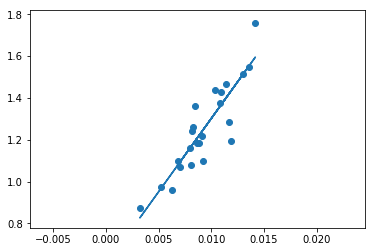

In [230]:
plot_list=['Si','Ca']
fig,ax=plt.subplots()
ax.scatter((cts_check[plot_list[0]]/cts_check[plot_list[1]]),(reference_conc[plot_list[0]]/reference_conc[plot_list[1]]))
stat=stats.linregress(((cts_check[plot_list[0]]/cts_check[plot_list[1]]),
                       (reference_conc[plot_list[0]]/reference_conc[plot_list[1]])))
ax.plot((cts_check[plot_list[0]]/cts_check[plot_list[1]]),
        (cts_check[plot_list[0]]/cts_check[plot_list[1]])*stat.slope+stat.intercept)

### Parameter Estimation
These are the parameters of the univariate log-ratio calibration of Weltje et al. 2008, as described in the supplementary information.

In [231]:
yis={}
for ratio in ref_conc_ratios.columns:
    yis[ratio]=np.array([np.log(ref_conc_ratios[ratio]),np.log(cts_check_ratios[ratio])]).transpose()
    
y_bars={}
for ratio in ref_conc_ratios.columns:
    y_bars[ratio]=np.array([yis[ratio][:,0].mean(),yis[ratio][:,1].mean()])
    
xis={}
for ratio in ref_conc_ratios.columns:
    xis[ratio]=np.array([yis[ratio][:,0]-y_bars[ratio][0],yis[ratio][:,1]-y_bars[ratio][1]]).transpose()
    
xtxs={}
for ratio in ref_conc_ratios.columns:
    xtxs[ratio]=np.dot(xis[ratio].transpose(),xis[ratio])

Fs={}
for ratio in ref_conc_ratios.columns:
    Fs[ratio]=(xtxs[ratio][0,0]-xtxs[ratio][1,1])/(2*xtxs[ratio][1,0])

Gs={}
for ratio in ref_conc_ratios.columns:
    Gs[ratio]=Fs[ratio]+np.sqrt(np.square(Fs[ratio])+1)

a_s={}
for ratio in ref_conc_ratios.columns:
    a_s[ratio]=Gs[ratio]/(np.sqrt(Gs[ratio])+1)
    
b_s={}
for ratio in ref_conc_ratios.columns:
    b_s[ratio]=1/(np.sqrt(Gs[ratio])+1)

alphas={}
for ratio in ref_conc_ratios.columns:
    alphas[ratio]=a_s[ratio]/b_s[ratio]
betas={}
for ratio in ref_conc_ratios.columns:
    betas[ratio]=y_bars[ratio][0]-alphas[ratio]*y_bars[ratio][1]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


### Calibrate XRF Scans

In [232]:
ln_wij_over_wid_xrf={}
for ratio in ref_conc_ratios.columns:
    ln_wij_over_wid_xrf[ratio]=alphas[ratio]*np.log(box_filt_ratios[ratio])+betas[ratio]

### Calibrate XRF data at calibration sample depths

In [233]:
ln_wij_over_wid_calibration={}
for ratio in ref_conc_ratios.columns:
    ln_wij_over_wid_calibration[ratio]=alphas[ratio]*np.log(cts_check_ratios[ratio])+betas[ratio]

### Here's a script that examines the correlation between calibrated xrf data and calibration sample concentrations

Text(0.1,0.9,'0.91')

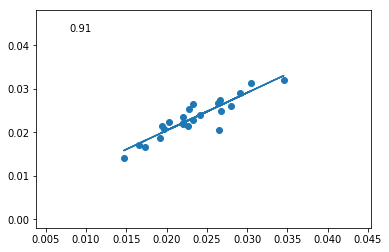

In [234]:
fig,ax=plt.subplots()
ratio='Ti/Ca'
ax.scatter(ref_conc_ratios[ratio],np.exp(ln_wij_over_wid_calibration[ratio]))
stat=stats.linregress(ref_conc_ratios[ratio],np.exp(ln_wij_over_wid_calibration[ratio]))
ax.plot(ref_conc_ratios[ratio],ref_conc_ratios[ratio]*stat.slope+stat.intercept)
ax.annotate(str(stat.rvalue)[:4],xy=(.1,.9),xycoords='axes fraction')

### Get out of log space and into concentrations

In [235]:
df_ln_wij_over_wid_calibration=pd.DataFrame(ln_wij_over_wid_calibration)
df_ln_wij_over_wid_calibration=df_ln_wij_over_wid_calibration[['Al/Ca','Si/Ca','K/Ca','Ca/Ca','Ti/Ca','Fe/Ca']]
df_ln_wij_over_wid_calibration['Ca/Ca']=0

df_ln_wij_over_wid_xrf=pd.DataFrame(ln_wij_over_wid_xrf)
df_ln_wij_over_wid_xrf=df_ln_wij_over_wid_xrf[['Al/Ca','Si/Ca','K/Ca','Ca/Ca','Ti/Ca','Fe/Ca']]
df_ln_wij_over_wid_xrf['Ca/Ca']=0

In [236]:
concentrations_xrf=pd.DataFrame(index=df_ln_wij_over_wid_xrf.index)
concentrations_calibration=pd.DataFrame(index=df_ln_wij_over_wid_calibration.index)

In [237]:
for element,ratio in zip(box_filt.columns,df_ln_wij_over_wid_xrf.columns):
    concentrations_xrf[element]=(np.exp(df_ln_wij_over_wid_xrf[ratio]).div(
        np.exp(df_ln_wij_over_wid_xrf).sum(axis=1))).values*100
for element,ratio in zip(box_filt.columns,df_ln_wij_over_wid_xrf.columns):
    concentrations_calibration[element]=(np.exp(df_ln_wij_over_wid_calibration[ratio]).div(
        np.exp(df_ln_wij_over_wid_calibration).sum(axis=1))).values*100

In [238]:
concentrations_xrf.head()

,Al,Si,K,Ca,Ti,Fe
Depth (m),,,,,,
0.057,12.397569,40.580861,0.725956,39.416320,0.785044,6.094250
0.059,12.222993,40.641402,0.713546,39.559973,0.782917,6.079169
0.061,11.993511,40.579159,0.698457,39.874779,0.777557,6.076536
0.063,11.797183,40.620147,0.685456,40.074396,0.776897,6.045921
0.065,11.875261,40.558156,0.669439,40.142478,0.773242,5.981424


### Export

In [239]:
concentrations_xrf.to_csv(data_path+'xrf_concentrations.csv')

## Compare final data

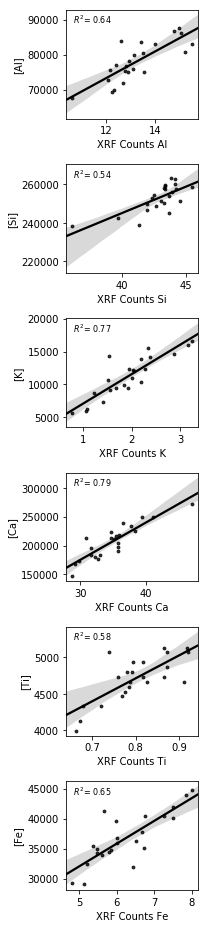

In [240]:
compare(concentrations_xrf,'calibrated_xrf_vs_calibration.png')